In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_curve
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
from keras.utils import np_utils
from sklearn.utils import shuffle

import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers import BatchNormalization
from keras.layers import ELU, PReLU, LeakyReLU
#from keras.layers.advanced_activations import ELU
from keras.initializers import glorot_uniform
from keras import backend as K
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam
from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score
#from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import save_model


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from keras.constraints import maxnorm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
NB_CLASSES = 4 # number of outputs = number of classes
VERBOSE = 1
BATCH_SIZE = 10
NB_EPOCH = 100
target_names = ['Non-MO', 'MO']
file_short = "D:/BMO/Main/savedModels/5input_model_short.h5"
file_mid1 = "D:/BMO/Main/savedModels/5input_model_mid1.h5"
file_mid2 = "D:/BMO/Main/savedModels/5input_model_mid2.h5"
file_long = "D:/BMO/Main/savedModels/5input_model_long.h5"
file_best = "D:/BMO/Main/savedModels/5input_model_best.h5"

In [3]:
symbol_length =   [1, 128, 1024, 1800, 2048]

In [4]:
%%time

print(".........Loading MO (2-state) dataset..........")

# sep separates each column and header = none means it is going to read from row 1
re2psk_2st = pd.read_csv('D:/BMO/Main/bigDataset/SNR-based/BPSK-2/real_snr05.csv',sep=',', header=None) 
im2psk_2st = pd.read_csv('D:/BMO/Main/bigDataset/SNR-based/BPSK-2/im_snr05.csv',sep=',', header=None)

# sep separates each column and header = none means it is going to read from row 1
re4psk_2st = pd.read_csv('D:/BMO/Main/bigDataset/SNR-based/QPSK-2/real_snr05.csv',sep=',', header=None) 
im4psk_2st = pd.read_csv('D:/BMO/Main/bigDataset/SNR-based/QPSK-2/im_snr05.csv',sep=',', header=None)

# sep separates each column and header = none means it is going to read from row 1
re16qam_2st = pd.read_csv('D:/BMO/Main/bigDataset/SNR-based/16-QAM-2/real_snr05.csv',sep=',', header=None) 
im16qam_2st = pd.read_csv('D:/BMO/Main/bigDataset/SNR-based/16-QAM-2/im_snr05.csv',sep=',', header=None)

# sep separates each column and header = none means it is going to read from row 1
re64qam_2st = pd.read_csv('D:/BMO/Main/bigDataset/SNR-based/64-QAM-2/real_snr05.csv',sep=',', header=None) 
im64qam_2st = pd.read_csv('D:/BMO/Main/bigDataset/SNR-based/64-QAM-2/im_snr05.csv',sep=',', header=None)


#merge two dataframes into one
df2psk_2st = re2psk_2st + im2psk_2st * 1j
df2psk_2st['Mod'] = 0 # 0 = BPSK 2-state
#merge two dataframes into one
df4psk_2st = re4psk_2st + im4psk_2st * 1j
df4psk_2st['Mod'] = 1 # 1 = QPSK 2-state
#merge two dataframes into one
df16qam_2st = re16qam_2st + im16qam_2st * 1j
df16qam_2st['Mod'] = 2 # 2 = 16-QAM 2-state
#merge two dataframes into one
df64qam_2st = re64qam_2st + im64qam_2st * 1j
df64qam_2st['Mod'] = 3 # 3 = 64-QAM 2-state

# combine all
df_2st = df2psk_2st.append(df4psk_2st)
df_2st = df_2st.append(df16qam_2st)
df_2st = df_2st.append(df64qam_2st)

#df_mo = df_2st
#df_mo = df_mo.sample(frac = 1)
print('df_mo Shape = ', df_2st.shape)

.........Loading MO (2-state) dataset..........
df_mo Shape =  (28000, 2049)
CPU times: total: 44.3 s
Wall time: 44.2 s


In [5]:
print("..........Combining all data..........")

# combine all
#df = df_mo.append(df_nonmo)
df_all = df_2st.sample(frac = 1)
print('df_all Shape = ', df_all.shape)
print("..........Shuffling done..........")

# reducing samples to tune only
#df_all = df_all.iloc[:16384]
print('df_all Size = ', df_all.size)
print('Dimension = ', df_all.ndim)
print('Combined Shape = ', df_all.shape)

..........Combining all data..........
df_all Shape =  (28000, 2049)
..........Shuffling done..........
df_all Size =  57372000
Dimension =  2
Combined Shape =  (28000, 2049)


In [6]:
%%time

f1_bp = []
f1_qp = []
f1_16 = []
f1_64 = []
re_bp = []
re_qp = []
re_16 = []
re_64 = []
pr_bp = []
pr_qp = []
pr_16 = []
pr_64 = []
ac_bp = []
ac_qp = []
ac_16 = []
ac_64 = []

f1mc_bp = []
f1mc_qp = []
f1mc_16 = []
f1mc_64 = []
remc_bp = []
remc_qp = []
remc_16 = []
remc_64 = []
prmc_bp = []
prmc_qp = []
prmc_16 = []
prmc_64 = []
acmc_bp = []
acmc_qp = []
acmc_16 = []
acmc_64 = []

accuracy = []
f1score = []
loss = []
precision = []
false_pos = []
true_pos = []
recall = []

for LENGTH in symbol_length:
    
    # Separating X and y
    y = df_all['Mod'] # 1D targer vector
    X = df_all.drop(columns='Mod')

    INPUT_SHAPE = (LENGTH,1)

    X.drop(X.iloc[:, LENGTH:2048], inplace = True, axis = 1)

    X = np.expand_dims(X, -1)

    # Split into training/testing sets with 20% split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1) 

    print("..........Training set..........")
    print(X_train.shape)
    print(y_train.shape)
    print("..........Validation set..........")
    print(X_val.shape)
    print(y_val.shape)
    print("..........Testing set..........")
    print(X_test.shape)
    print(y_test.shape)

    # Convert class vectors to categorical classes matrices
    y_train = np_utils.to_categorical(y_train, NB_CLASSES)
    y_test = np_utils.to_categorical(y_test, NB_CLASSES)
    y_val = np_utils.to_categorical(y_val, NB_CLASSES)

    from keras.constraints import maxnorm

    # Function to create model, required for KerasClassifier
    def create_model():
        # create model
        model = Sequential()
        filter_num = ['None',32,64,128,256]
        kernel_size = ['None',8,8,8,8]
        conv_stride_size = ['None',1,1,1,1]
        pool_stride_size = ['None',4,4,4,4]
        pool_size = ['None',8,8,8,8]
        batch_size = 10
        dropout_rate =0.0
        # Feature extraction
        model.add(Conv1D(filters=filter_num[1], kernel_size=kernel_size[1], input_shape=INPUT_SHAPE,
                             strides=conv_stride_size[1], padding='same',
                             name='convolution1'))
        model.add(BatchNormalization(axis=-1))
        model.add(ELU(alpha=1.0, name='activation1'))
        model.add(MaxPooling1D(pool_size=pool_size[1], strides=pool_stride_size[1],
                                   padding='same', name='pool1'))
        model.add(Dropout(dropout_rate, name='dropout1'))
        
        model.add(BatchNormalization(axis=-1))
        model.add(ELU(alpha=1.0, name='activation2'))
        model.add(MaxPooling1D(pool_size=pool_size[2], strides=pool_stride_size[2],
                                   padding='same', name='pool2'))
        model.add(Dropout(dropout_rate, name='dropout2'))

        # Output layer
        model.add(Flatten(name='flatten1'))
        model.add(Dense(NB_CLASSES, kernel_initializer=glorot_uniform(seed=0), name='dense1'))
        model.add(Activation('softmax', name="softmax"))

        # Compile model
        model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.01, momentum=0.6), metrics=["accuracy"])

        return model

    model = create_model()
    # simple early stopping
    es_lr = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    mc_lr = ModelCheckpoint(file_best, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    # fit model
    model_history = model.fit(X_train, y_train, epochs=NB_EPOCH, verbose=VERBOSE, 
                                validation_data=(X_val, y_val), callbacks=[es_lr, mc_lr])
  #  model_history = model.fit(X_train, y_train, epochs=NB_EPOCH, verbose=VERBOSE, 
   #                             validation_data=(X_val, y_val))
    
    
    if(LENGTH==128):
        save_model(model, file_short)
        print("Saved model to disk")
        print('Confusion Matrix when Symbol Length ', LENGTH)
        cm_short = confusion_matrix(y_test1, y_pred1)
        cmratio_short = cm_short.astype('float') / cm_short.sum(axis=1)[:, np.newaxis]
        cmratio_short= np.around(cmratio_short.astype('float') / cmratio_short.sum(axis=1)[:, np.newaxis], decimals=1)
        
    if(LENGTH==512):
        save_model(model, file_mid1)
        print("Saved model to disk")
        print('Confusion Matrix when Symbol Length ', LENGTH)
        cm_mid1 = confusion_matrix(y_test1, y_pred1)
        cmratio_mid1 = cm_mid1.astype('float') / cm_mid1.sum(axis=1)[:, np.newaxis]
        cmratio_mid1= np.around(cmratio_mid1.astype('float') / cmratio_mid1.sum(axis=1)[:, np.newaxis], decimals=1)
        
    if(LENGTH==1536):
        save_model(model, file_mid2)
        print("Saved model to disk")
        print('Confusion Matrix when Symbol Length ', LENGTH)
        cm_mid2 = confusion_matrix(y_test1, y_pred1)
        cmratio_mid2 = cm_mid2.astype('float') / cm_mid2.sum(axis=1)[:, np.newaxis]
        cmratio_mid2= np.around(cmratio_mid2.astype('float') / cmratio_mid2.sum(axis=1)[:, np.newaxis], decimals=1)
        
    if(LENGTH==2048):
        save_model(model, file_long)
        print("Saved model to disk")
        print('Confusion Matrix when Symbol Length ', LENGTH)
        cm_long = confusion_matrix(y_test1, y_pred1)
        cmratio_long = cm_long.astype('float') / cm_long.sum(axis=1)[:, np.newaxis]
        cmratio_long= np.around(cmratio_long.astype('float') / cmratio_long.sum(axis=1)[:, np.newaxis], decimals=1)
        
    # Start evaluating model with testing data
    score_test = model.evaluate(X_test, y_test, verbose=VERBOSE)
    y_pred = model.predict(X_test)
    
    y_pred1=np.argmax(y_pred, axis=1)
    y_test1=np.argmax(y_test, axis=1)
    #cm = confusion_matrix(y_test1, y_pred1
    
    acc = score_test[1]
    accuracy.append(acc)
    
    ls = score_test[0]
    loss.append(ls)
    
    f1s = f1_score(y_test1, y_pred1, average=None)
    f1score.append((f1s[0]+f1s[1])/2)
    print(f1s)
    for index, val in np.ndenumerate(f1s):
            if (index[0]==0): 
                f1bp = val
            if (index[0]==1): 
                f1qp = val
            if (index[0]==2):
                f116 = val
            if (index[0]==3): 
                f164 = val
           
    f1_bp.append(f1bp)
    f1_qp.append(f1qp)
    f1_16.append(f116)
    f1_64.append(f164)
    
    
    cm = confusion_matrix(y_test1, y_pred1)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #print('Confusion Matrix when Symbol Length ', LENGTH)
    #f = sns.heatmap(cm, cmap='Greens', annot=True, square=True, yticklabels = True)
    #cmratio = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #plt.rcParams["figure.figsize"] = (7.5,7.5)
    #plt.rcParams.update({'font.size': 14})
    #f = sns.heatmap(cm, cmap='Purples', annot=True, square=True, yticklabels = True)
    
    accuracys = cm.diagonal()
    #acc = accuracy.reshape(-1,1)
    print(accuracys)
    for index, val in np.ndenumerate(accuracys):
            if (index[0]==0): 
                abp = val
            if (index[0]==1): 
                aqp = val
            if (index[0]==2):
                a16 = val
            if (index[0]==3): 
                a64 = val
           
    ac_bp.append(abp)
    ac_qp.append(aqp)
    ac_16.append(a16)
    ac_64.append(a64)

..........Training set..........
(20160, 1, 1)
(20160,)
..........Validation set..........
(2240, 1, 1)
(2240,)
..........Testing set..........
(5600, 1, 1)
(5600,)
Epoch 1/100
624/630 [============================>.] - ETA: 0s - loss: 1.4009 - accuracy: 0.2528
Epoch 1: val_accuracy improved from -inf to 0.25223, saving model to D:/BMO/Main/savedModels\5input_model_best.h5
630/630 [==============================] - 2s 2ms/step - loss: 1.4008 - accuracy: 0.2526 - val_loss: 1.3886 - val_accuracy: 0.2522
Epoch 2/100
617/630 [============================>.] - ETA: 0s - loss: 1.3907 - accuracy: 0.2439
Epoch 2: val_accuracy did not improve from 0.25223
630/630 [==============================] - 1s 2ms/step - loss: 1.3906 - accuracy: 0.2446 - val_loss: 1.3918 - val_accuracy: 0.2446
Epoch 3/100
624/630 [============================>.] - ETA: 0s - loss: 1.3903 - accuracy: 0.2510
Epoch 3: val_accuracy did not improve from 0.25223
630/630 [==============================] - 1s 2ms/step - loss: 1.3

630/630 [==============================] - 1s 1ms/step - loss: 1.3895 - accuracy: 0.2488 - val_loss: 1.3866 - val_accuracy: 0.2746
Epoch 29/100
603/630 [===========================>..] - ETA: 0s - loss: 1.3900 - accuracy: 0.2484
Epoch 29: val_accuracy did not improve from 0.27455
630/630 [==============================] - 1s 1ms/step - loss: 1.3900 - accuracy: 0.2477 - val_loss: 1.3951 - val_accuracy: 0.2402
Epoch 30/100
608/630 [===========================>..] - ETA: 0s - loss: 1.3895 - accuracy: 0.2459
Epoch 30: val_accuracy did not improve from 0.27455
630/630 [==============================] - 1s 1ms/step - loss: 1.3896 - accuracy: 0.2457 - val_loss: 1.3864 - val_accuracy: 0.2638
Epoch 31/100
623/630 [============================>.] - ETA: 0s - loss: 1.3895 - accuracy: 0.2495
Epoch 31: val_accuracy did not improve from 0.27455
630/630 [==============================] - 1s 1ms/step - loss: 1.3895 - accuracy: 0.2494 - val_loss: 1.3870 - val_accuracy: 0.2388
Epoch 32/100
615/630 [====

630/630 [==============================] - 1s 2ms/step - loss: 1.3892 - accuracy: 0.2480 - val_loss: 1.3850 - val_accuracy: 0.2772
Epoch 58/100
610/630 [============================>.] - ETA: 0s - loss: 1.3885 - accuracy: 0.2527
Epoch 58: val_accuracy did not improve from 0.27723
630/630 [==============================] - 1s 1ms/step - loss: 1.3886 - accuracy: 0.2528 - val_loss: 1.3888 - val_accuracy: 0.2433
Epoch 59/100
619/630 [============================>.] - ETA: 0s - loss: 1.3890 - accuracy: 0.2497
Epoch 59: val_accuracy did not improve from 0.27723
630/630 [==============================] - 1s 1ms/step - loss: 1.3890 - accuracy: 0.2491 - val_loss: 1.3953 - val_accuracy: 0.2482
Epoch 60/100
611/630 [============================>.] - ETA: 0s - loss: 1.3886 - accuracy: 0.2525
Epoch 60: val_accuracy did not improve from 0.27723
630/630 [==============================] - 1s 1ms/step - loss: 1.3886 - accuracy: 0.2525 - val_loss: 1.3871 - val_accuracy: 0.2531
Epoch 61/100
626/630 [====

620/630 [============================>.] - ETA: 0s - loss: 1.0237 - accuracy: 0.5340
Epoch 7: val_accuracy did not improve from 0.51920
630/630 [==============================] - 3s 4ms/step - loss: 1.0241 - accuracy: 0.5337 - val_loss: 1.0444 - val_accuracy: 0.5116
Epoch 8/100
629/630 [============================>.] - ETA: 0s - loss: 1.0163 - accuracy: 0.5365
Epoch 8: val_accuracy improved from 0.51920 to 0.53661, saving model to D:/BMO/Main/savedModels\5input_model_best.h5
630/630 [==============================] - 3s 4ms/step - loss: 1.0163 - accuracy: 0.5367 - val_loss: 1.0177 - val_accuracy: 0.5366
Epoch 9/100
622/630 [============================>.] - ETA: 0s - loss: 1.0072 - accuracy: 0.5415
Epoch 9: val_accuracy did not improve from 0.53661
630/630 [==============================] - 3s 4ms/step - loss: 1.0068 - accuracy: 0.5417 - val_loss: 1.0064 - val_accuracy: 0.5366
Epoch 10/100
624/630 [============================>.] - ETA: 0s - loss: 1.0047 - accuracy: 0.5454
Epoch 10: v

Epoch 35/100
630/630 [==============================] - ETA: 0s - loss: 0.9611 - accuracy: 0.5746
Epoch 35: val_accuracy did not improve from 0.56607
630/630 [==============================] - 3s 4ms/step - loss: 0.9611 - accuracy: 0.5746 - val_loss: 0.9727 - val_accuracy: 0.5612
Epoch 36/100
629/630 [============================>.] - ETA: 0s - loss: 0.9591 - accuracy: 0.5730
Epoch 36: val_accuracy did not improve from 0.56607
630/630 [==============================] - 3s 4ms/step - loss: 0.9590 - accuracy: 0.5730 - val_loss: 0.9658 - val_accuracy: 0.5621
Epoch 37/100
625/630 [============================>.] - ETA: 0s - loss: 0.9542 - accuracy: 0.5733
Epoch 37: val_accuracy did not improve from 0.56607
630/630 [==============================] - 3s 4ms/step - loss: 0.9540 - accuracy: 0.5733 - val_loss: 0.9760 - val_accuracy: 0.5638
Epoch 38/100
620/630 [============================>.] - ETA: 0s - loss: 0.9532 - accuracy: 0.5719
Epoch 38: val_accuracy did not improve from 0.56607
630/630

630/630 [==============================] - ETA: 0s - loss: 0.4333 - accuracy: 0.8234
Epoch 5: val_accuracy improved from 0.79420 to 0.79554, saving model to D:/BMO/Main/savedModels\5input_model_best.h5
630/630 [==============================] - 15s 24ms/step - loss: 0.4333 - accuracy: 0.8234 - val_loss: 0.4612 - val_accuracy: 0.7955
Epoch 6/100
629/630 [============================>.] - ETA: 0s - loss: 0.4151 - accuracy: 0.8307
Epoch 6: val_accuracy did not improve from 0.79554
630/630 [==============================] - 15s 24ms/step - loss: 0.4151 - accuracy: 0.8307 - val_loss: 0.5687 - val_accuracy: 0.7826
Epoch 7/100
630/630 [==============================] - ETA: 0s - loss: 0.4112 - accuracy: 0.8289
Epoch 7: val_accuracy improved from 0.79554 to 0.80357, saving model to D:/BMO/Main/savedModels\5input_model_best.h5
630/630 [==============================] - 15s 24ms/step - loss: 0.4112 - accuracy: 0.8289 - val_loss: 0.4653 - val_accuracy: 0.8036
Epoch 8/100
630/630 [================

629/630 [============================>.] - ETA: 0s - loss: 0.4794 - accuracy: 0.8002
Epoch 2: val_accuracy did not improve from 0.79777
630/630 [==============================] - 24s 38ms/step - loss: 0.4794 - accuracy: 0.8002 - val_loss: 0.5959 - val_accuracy: 0.7442
Epoch 3/100
629/630 [============================>.] - ETA: 0s - loss: 0.4076 - accuracy: 0.8346
Epoch 3: val_accuracy improved from 0.79777 to 0.83259, saving model to D:/BMO/Main/savedModels\5input_model_best.h5
630/630 [==============================] - 24s 38ms/step - loss: 0.4075 - accuracy: 0.8345 - val_loss: 0.3865 - val_accuracy: 0.8326
Epoch 4/100
629/630 [============================>.] - ETA: 0s - loss: 0.3652 - accuracy: 0.8511
Epoch 4: val_accuracy did not improve from 0.83259
630/630 [==============================] - 24s 39ms/step - loss: 0.3655 - accuracy: 0.8510 - val_loss: 0.4684 - val_accuracy: 0.8107
Epoch 5/100
629/630 [============================>.] - ETA: 0s - loss: 0.3113 - accuracy: 0.8754
Epoch 

630/630 [==============================] - 30s 47ms/step - loss: 0.4516 - accuracy: 0.8121 - val_loss: 0.3691 - val_accuracy: 0.8384
Epoch 3/100
629/630 [============================>.] - ETA: 0s - loss: 0.3944 - accuracy: 0.8390
Epoch 3: val_accuracy improved from 0.83839 to 0.85312, saving model to D:/BMO/Main/savedModels\5input_model_best.h5
630/630 [==============================] - 30s 47ms/step - loss: 0.3944 - accuracy: 0.8390 - val_loss: 0.3454 - val_accuracy: 0.8531
Epoch 4/100
630/630 [==============================] - ETA: 0s - loss: 0.3495 - accuracy: 0.8571
Epoch 4: val_accuracy did not improve from 0.85312
630/630 [==============================] - 29s 47ms/step - loss: 0.3495 - accuracy: 0.8571 - val_loss: 0.3438 - val_accuracy: 0.8527
Epoch 5/100
629/630 [============================>.] - ETA: 0s - loss: 0.3529 - accuracy: 0.8603
Epoch 5: val_accuracy did not improve from 0.85312
630/630 [==============================] - 30s 47ms/step - loss: 0.3528 - accuracy: 0.8604 

In [7]:
print("Symbol series length = ", LENGTH)

y_pred1=np.argmax(y_pred, axis=1)
y_test1=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test1, y_pred1)
print(cm)
#f = sns.heatmap(cm, cmap='Purples', annot=True, square=True, yticklabels = True)

Symbol series length =  2048
[[1130  165    2   91]
 [ 378  962    4   38]
 [   3    2 1341    0]
 [  57   16    0 1411]]


In [8]:
print(accuracy)

[0.2475000023841858, 0.560535728931427, 0.8078571557998657, 0.8842856884002686, 0.8650000095367432]


[0.2475000023841858, 0.560535728931427, 0.8078571557998657, 0.8842856884002686, 0.8650000095367432]
[1.389981746673584, 0.9699782133102417, 0.5367564558982849, 0.3613000810146332, 0.43137648701667786]
[0.28103618016244153, 0.4253542978382775, 0.6968890628532808, 0.8072026243165317, 0.7629619058685815]


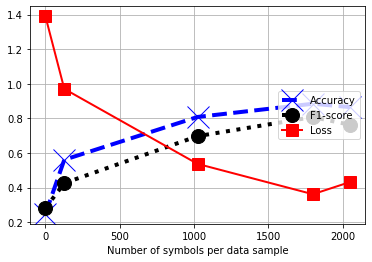

In [9]:
print(accuracy)
print(loss)
print(f1score)
# Plot Graph
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams.update({'font.size': 30})

fig, ax1 = plt.subplots()

ax1.plot(symbol_length, accuracy, color='b', linestyle='dashed', linewidth =4,
         marker='x', markerfacecolor='white', markersize=22, label='Accuracy')
ax1.plot(symbol_length, f1score, color='k', linestyle=':', linewidth =4,
         marker='o', markerfacecolor='k', markersize=14, label='F1-score')
ax1.plot(symbol_length, loss, color='r', linestyle='-', linewidth = 2,
         marker='s', markerfacecolor='r', markersize=12, label='Loss')

ax1.set_xlabel('Number of symbols per data sample')
#ax1.set_ylabel('Score')
plt.grid()
#plt.ylim(0.14, 1.0)
# ask matplotlib for the plotted objects and their labels
lines, labels = ax1.get_legend_handles_labels()
#lines2, labels2 = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='center right')

plt.show()